In [1]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [2]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

# **Data**

In [3]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
  
    if trim is not None:
        image_paths = image_paths[:trim]
        


                
    if mask:
        
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [4]:
def show_image(image, title=None, cmap=None, alpha=1):

    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):

    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [5]:
SIZE = 256
root_path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [6]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [7]:

image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

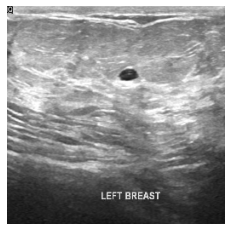

In [8]:

show_image(load_image(image_paths[0], SIZE))

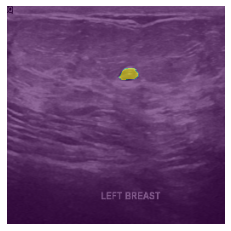

In [9]:

show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

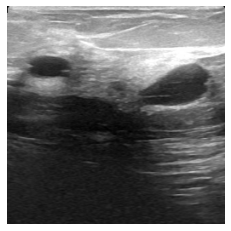

In [10]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

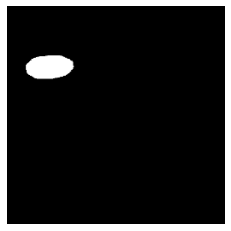

In [11]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

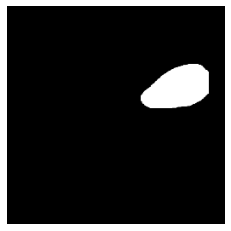

In [12]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

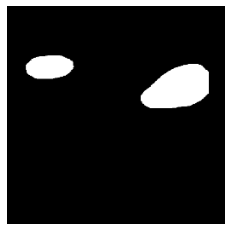

In [13]:
img = np.zeros((1,SIZE,SIZE,3)) # 1 * 256 * 256 * 3(rgb)
mask1 = load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2 
img = img[0,:,:,0] 

show_image(img, cmap='gray')

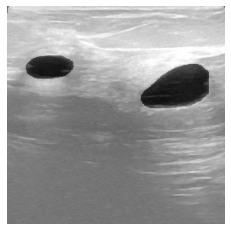

In [14]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

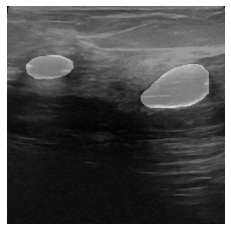

In [15]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()

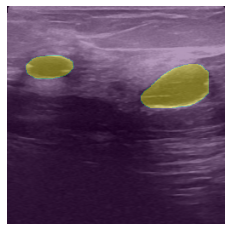

In [16]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()

## **Data Work**

In [17]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

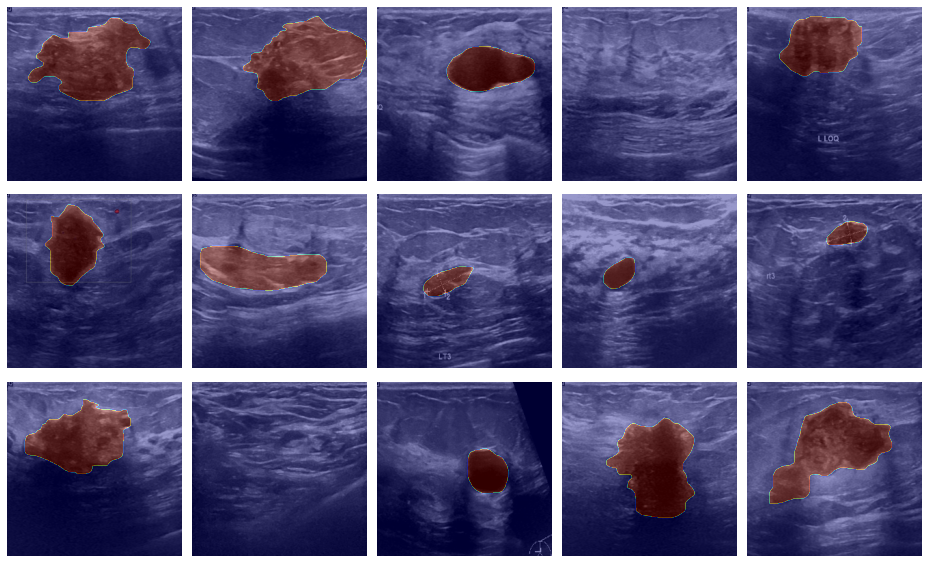

In [18]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

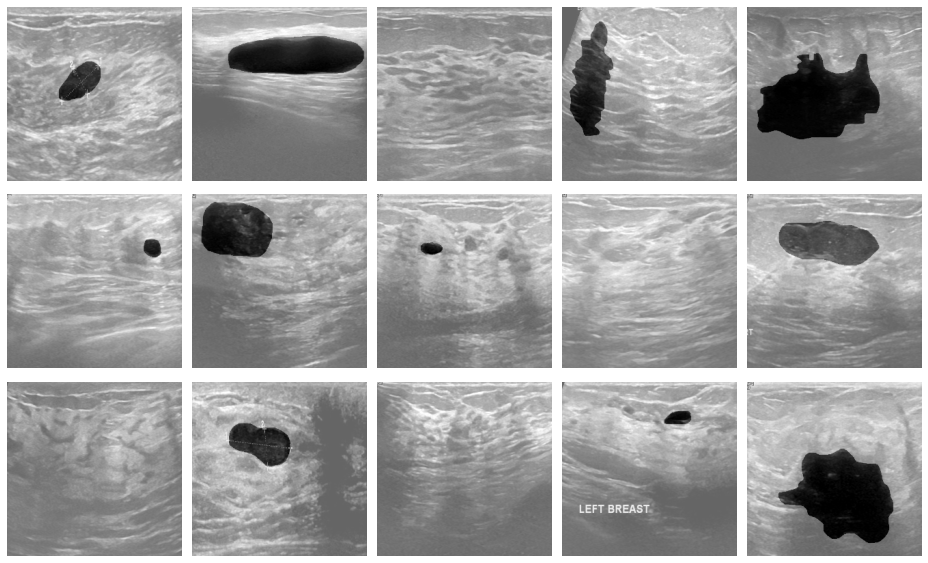

In [19]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

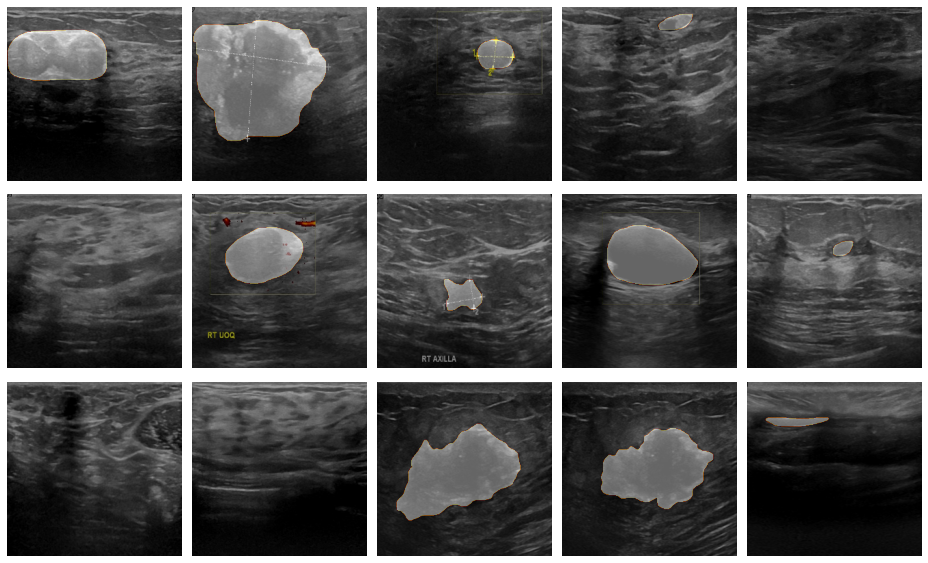

In [20]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

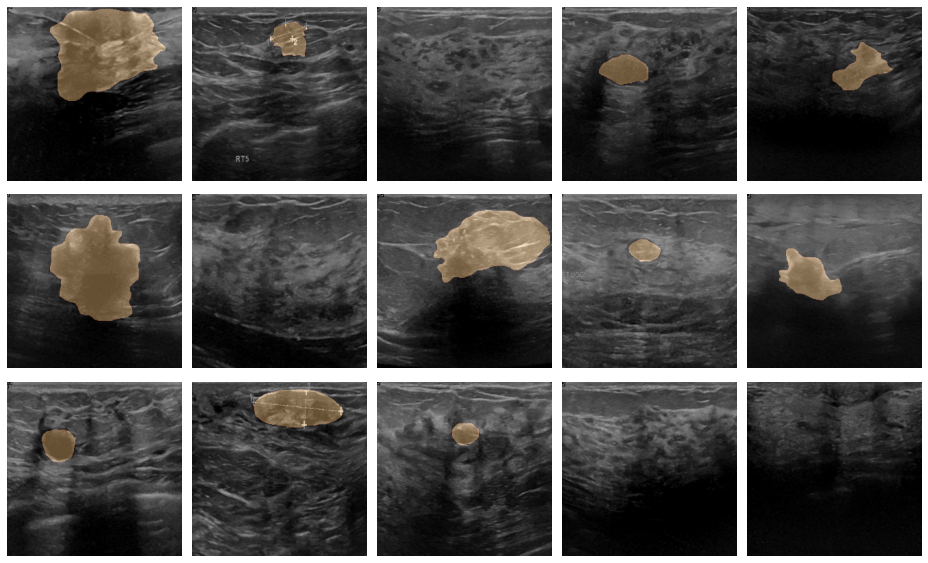

In [21]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# **Encoder**

In [22]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
       
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D() #  pool_size=2

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [23]:
class DecoderBlock(Layer):
  
    def __init__(self, filters, rate, **kwargs):
     
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X 
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [24]:
class AttentionGate(Layer):
  
    def __init__(self, filters, bn, **kwargs):
       
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip]) 
        x = self.resample(x)
        f = Multiply()([x, skip_X]) 
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# **Custom Callback**

In [25]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
      
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

# **Attention UNet**

In [26]:
# Inputs
input_layer = Input(shape=images.shape[-3:]) # 输入层 图像变为张量 n*256*256*3


p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)


# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True)
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

# **Training**

Epoch 1/20
97/97 [==============================] - 26s 152ms/step - loss: 0.3024 - accuracy: 0.8976 - IoU: 0.4541 - val_loss: 0.2575 - val_accuracy: 0.9813 - val_IoU: 0.4909


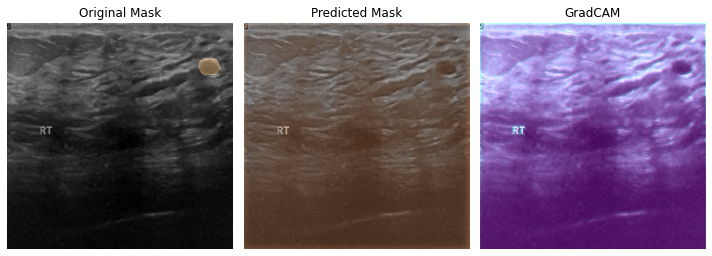

Epoch 2/20
97/97 [==============================] - 13s 132ms/step - loss: 0.2369 - accuracy: 0.9093 - IoU: 0.4533 - val_loss: 0.1950 - val_accuracy: 0.9813 - val_IoU: 0.4909


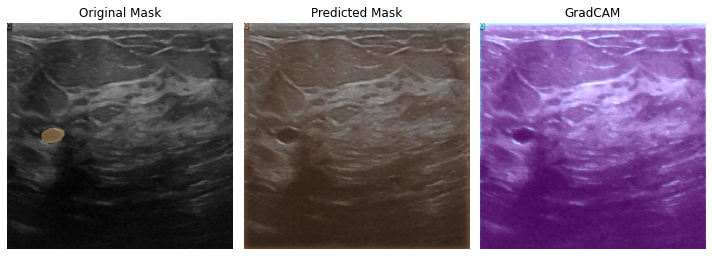

Epoch 3/20
97/97 [==============================] - 13s 133ms/step - loss: 0.2156 - accuracy: 0.9187 - IoU: 0.4574 - val_loss: 0.1225 - val_accuracy: 0.9813 - val_IoU: 0.4909


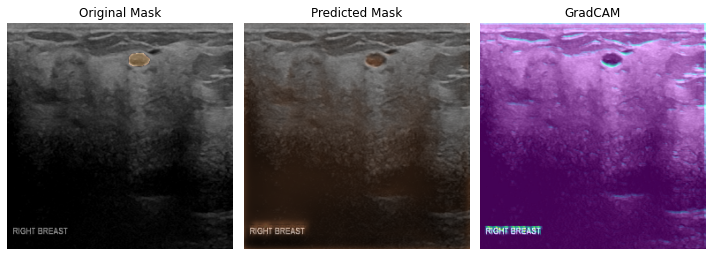

Epoch 4/20
97/97 [==============================] - 13s 132ms/step - loss: 0.2131 - accuracy: 0.9202 - IoU: 0.4541 - val_loss: 0.1054 - val_accuracy: 0.9813 - val_IoU: 0.4909


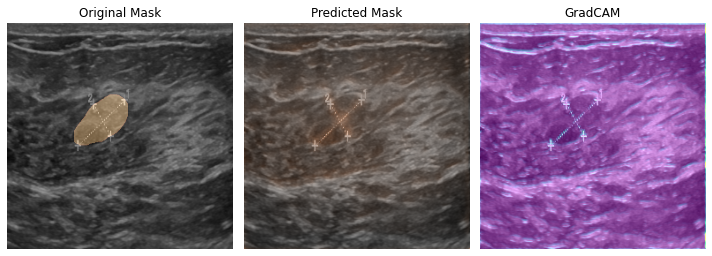

Epoch 5/20
97/97 [==============================] - 13s 133ms/step - loss: 0.2054 - accuracy: 0.9248 - IoU: 0.4549 - val_loss: 0.0838 - val_accuracy: 0.9814 - val_IoU: 0.4909


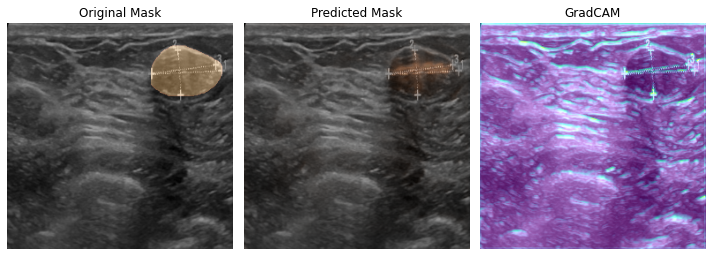

Epoch 6/20
97/97 [==============================] - 13s 133ms/step - loss: 0.2062 - accuracy: 0.9229 - IoU: 0.4545 - val_loss: 0.1307 - val_accuracy: 0.9804 - val_IoU: 0.4909


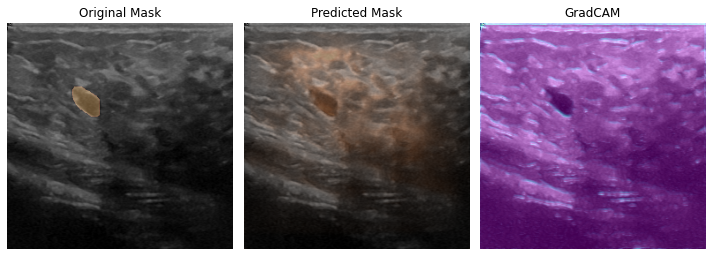

Epoch 7/20
97/97 [==============================] - 13s 132ms/step - loss: 0.1960 - accuracy: 0.9259 - IoU: 0.4550 - val_loss: 0.0673 - val_accuracy: 0.9830 - val_IoU: 0.4909


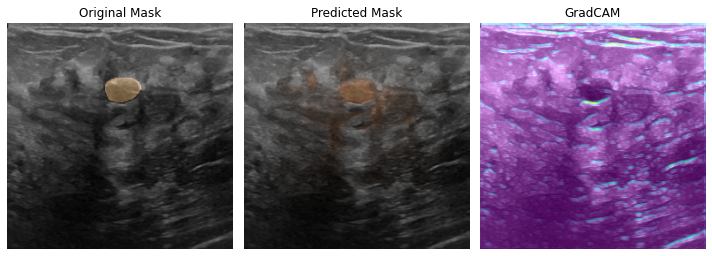

Epoch 8/20
97/97 [==============================] - 13s 133ms/step - loss: 0.1902 - accuracy: 0.9281 - IoU: 0.4562 - val_loss: 0.1296 - val_accuracy: 0.9774 - val_IoU: 0.4909


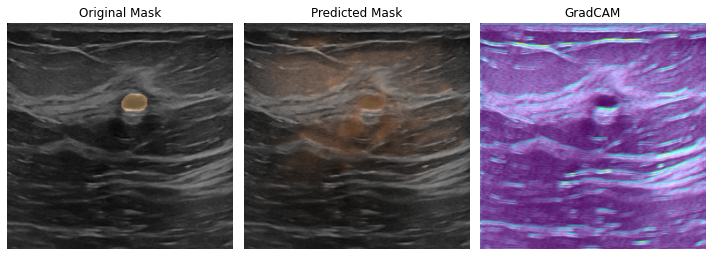

Epoch 9/20
97/97 [==============================] - 13s 132ms/step - loss: 0.1870 - accuracy: 0.9301 - IoU: 0.4561 - val_loss: 0.0711 - val_accuracy: 0.9826 - val_IoU: 0.4909


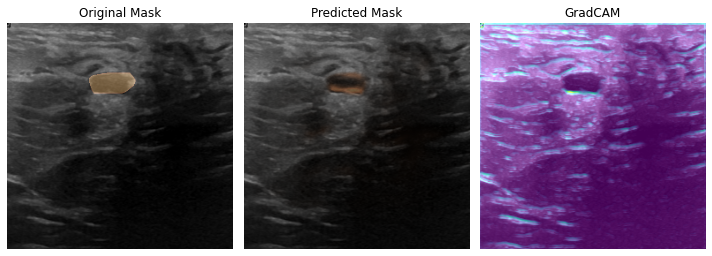

Epoch 10/20
97/97 [==============================] - 13s 132ms/step - loss: 0.1813 - accuracy: 0.9323 - IoU: 0.4561 - val_loss: 0.0796 - val_accuracy: 0.9803 - val_IoU: 0.4909


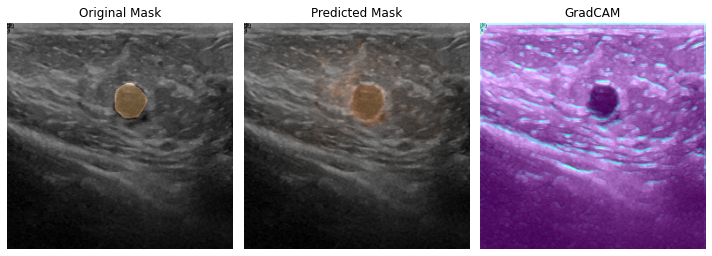

Epoch 11/20
97/97 [==============================] - 13s 132ms/step - loss: 0.1716 - accuracy: 0.9359 - IoU: 0.4567 - val_loss: 0.0616 - val_accuracy: 0.9841 - val_IoU: 0.4909


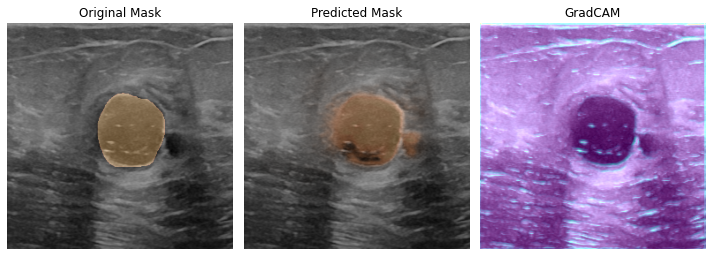

Epoch 12/20
97/97 [==============================] - 13s 132ms/step - loss: 0.1739 - accuracy: 0.9353 - IoU: 0.4554 - val_loss: 0.0602 - val_accuracy: 0.9839 - val_IoU: 0.4909


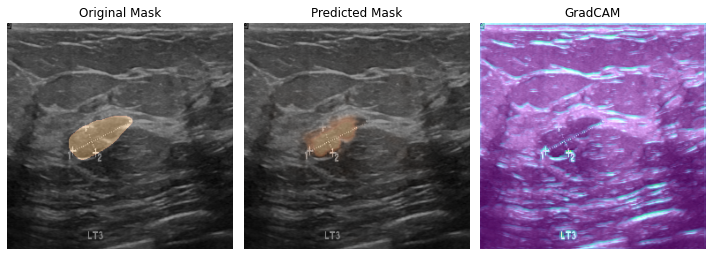

Epoch 13/20
97/97 [==============================] - 13s 132ms/step - loss: 0.1635 - accuracy: 0.9396 - IoU: 0.4566 - val_loss: 0.0617 - val_accuracy: 0.9801 - val_IoU: 0.4909


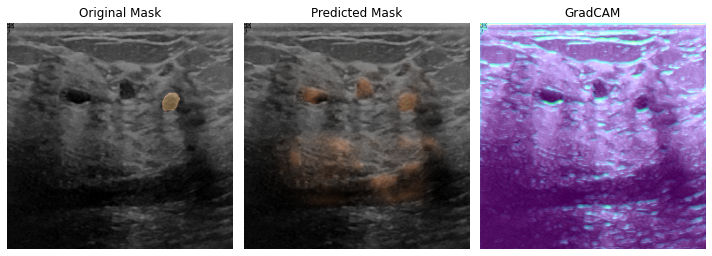

Epoch 14/20
97/97 [==============================] - 13s 132ms/step - loss: 0.1580 - accuracy: 0.9423 - IoU: 0.4573 - val_loss: 0.0719 - val_accuracy: 0.9812 - val_IoU: 0.4911


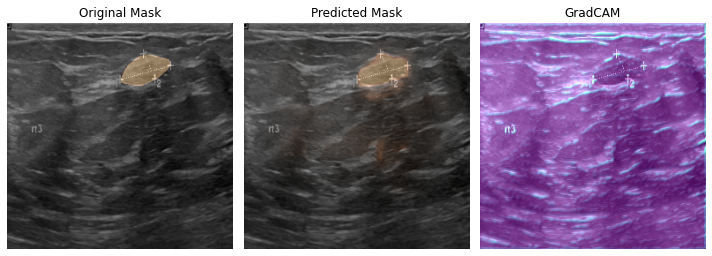

Epoch 15/20
97/97 [==============================] - 13s 132ms/step - loss: 0.1526 - accuracy: 0.9432 - IoU: 0.4568 - val_loss: 0.0806 - val_accuracy: 0.9772 - val_IoU: 0.4909


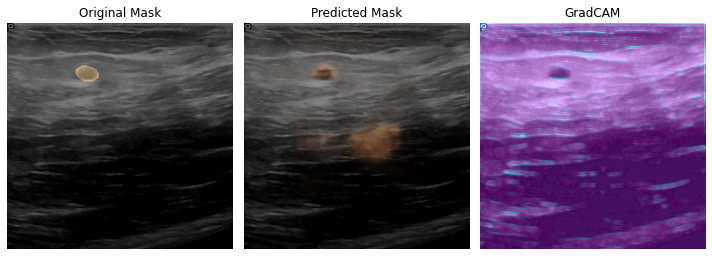

Epoch 16/20
97/97 [==============================] - 13s 133ms/step - loss: 0.1477 - accuracy: 0.9455 - IoU: 0.4581 - val_loss: 0.0599 - val_accuracy: 0.9816 - val_IoU: 0.4909


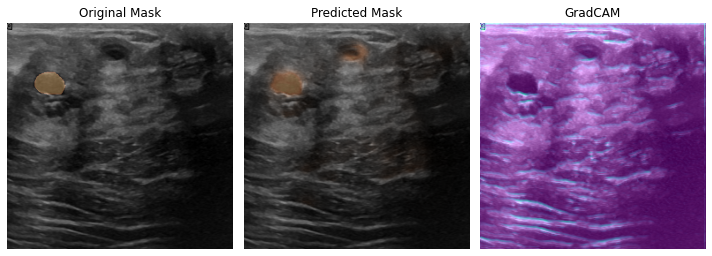

Epoch 17/20
97/97 [==============================] - 2s 17ms/step - loss: 0.1322 - accuracy: 0.9510 - IoU: 0.4584 - val_loss: 0.0664 - val_accuracy: 0.9811 - val_IoU: 0.4909


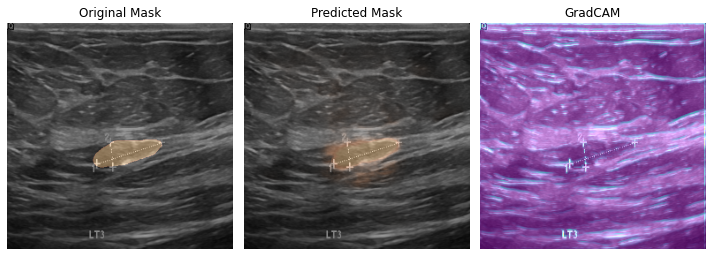

In [27]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split=0.2, 
    epochs=20, 
    steps_per_epoch=SPE, 
    batch_size=BATCH_SIZE, 
    callbacks=cb 
)

# **Evaluation**

In [33]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()
print(val_accuracy)


[0.9813379049301147, 0.9813379049301147, 0.9813379049301147, 0.9813379049301147, 0.9813764691352844, 0.9803717136383057, 0.9829856753349304, 0.977404773235321, 0.982585608959198, 0.980259895324707, 0.9841222763061523, 0.9839378595352173, 0.9800669550895691, 0.9811680912971497, 0.9772473573684692, 0.9816357493400574, 0.981063723564148]


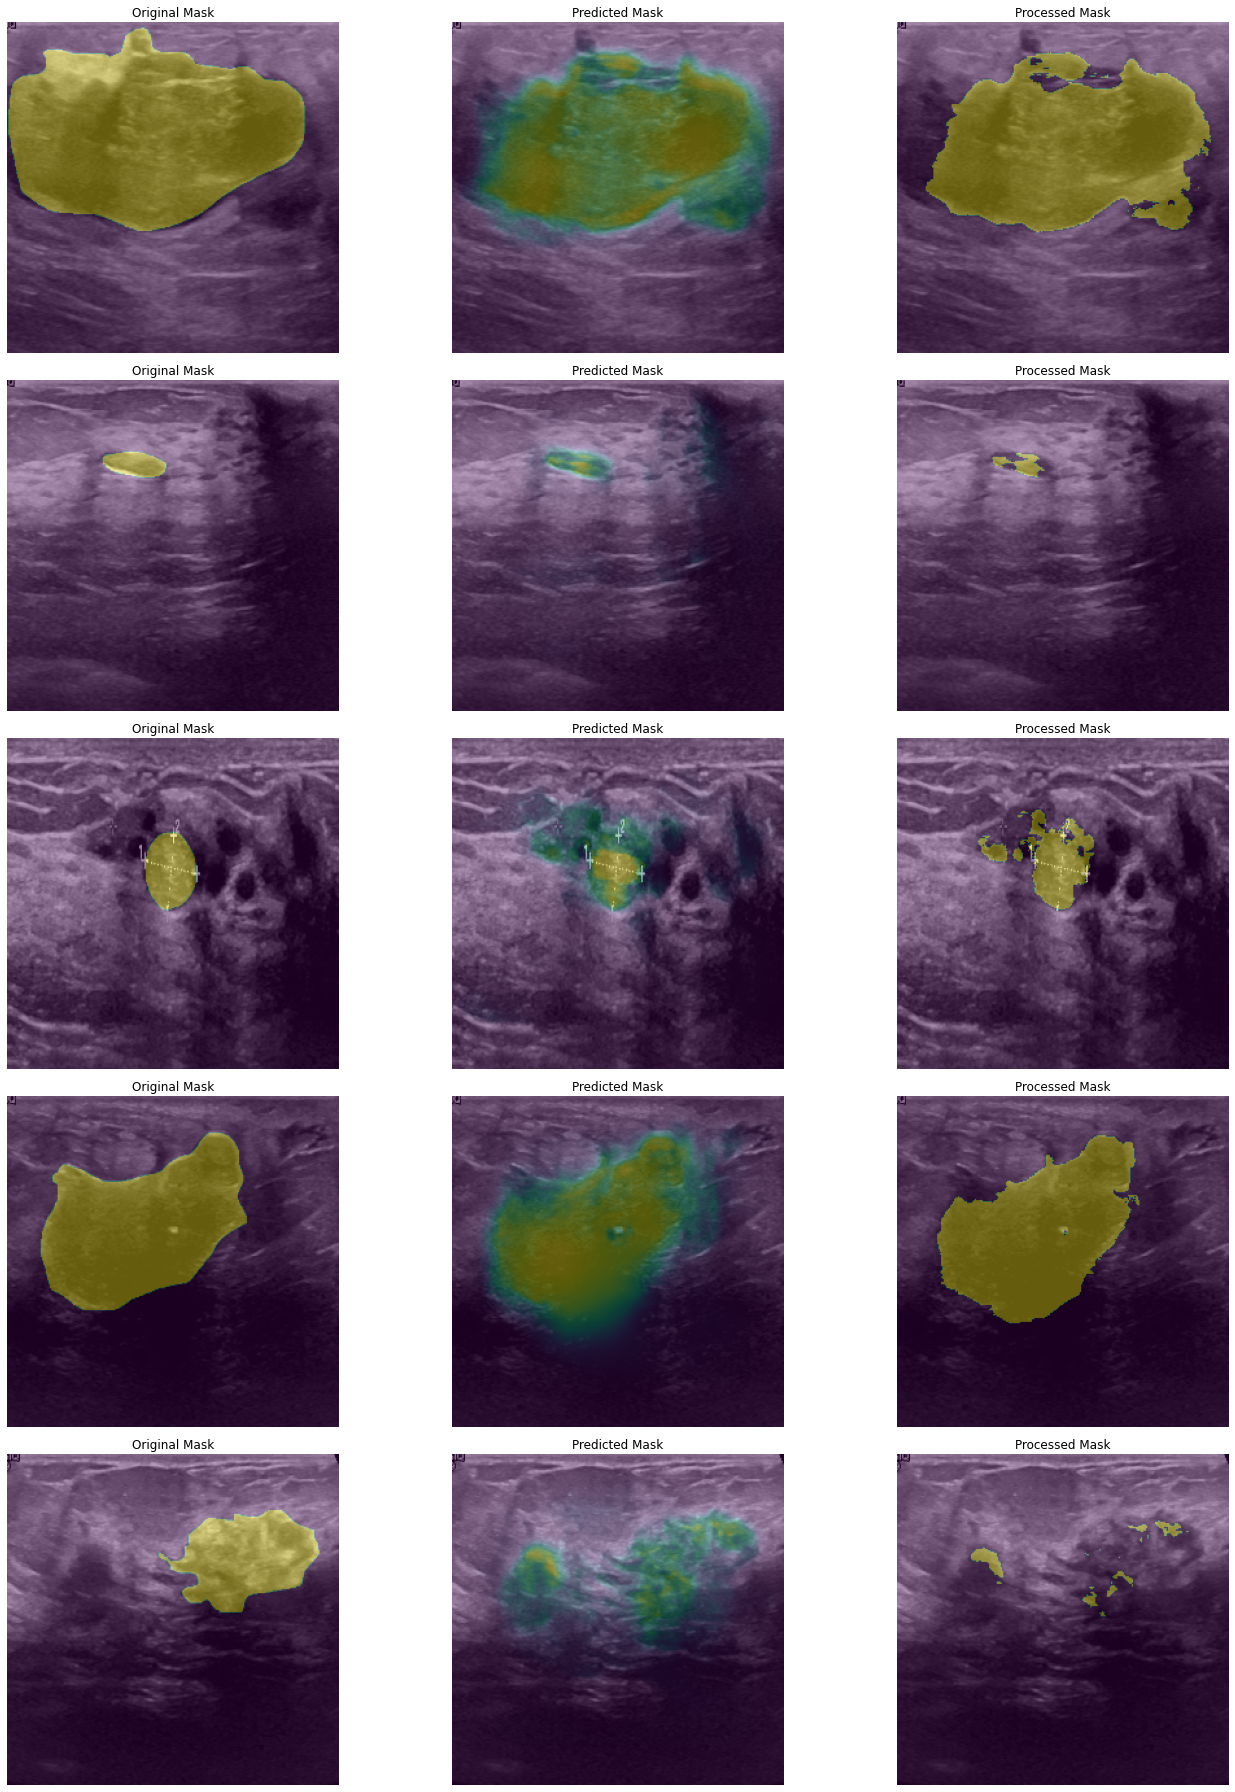

In [30]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [36]:
predictions = model.predict(images)

# Compute the mean IoU metric on the test set
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(masks, predictions)
print("Mean IoU on test set: {:.3f}".format(mean_iou.result()))

# Compute the precision and recall on the test set
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(masks, predictions)
recall.update_state(masks, predictions)

# Get precision and recall values
precision_value = precision.result()
recall_value = recall.result()

print("Precision on test set: {:.3f}".format(precision_value))
print("Recall on test set: {:.3f}".format(recall_value))

# Compute the F1 score on the test set
f1_score = 2 * (precision_value * recall_value) / (precision_value + recall_value)
print("F1 score on test set: {:.3f}".format(f1_score))

# Reset the metrics
mean_iou.reset_states()
precision.reset_states()
recall.reset_states()

Mean IoU on test set: 0.857
Precision on test set: 0.838
Recall on test set: 0.893
F1 score on test set: 0.884
